# Özel (Custom) Transformer

In [61]:
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer


👉 Bu veri setini kullanacağız:

In [62]:
data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Veri setindeki her bir gözlem, bir ürünün bir `seller_state`’ten bir `customer_state`’e teslim edilmesini temsil eder.  
- Diğer sütunlar, her bir ürünün paketleme özelliklerini açıklar.

🎯 Hedef, sipariş ile teslimat arasındaki gün sayısıdır.

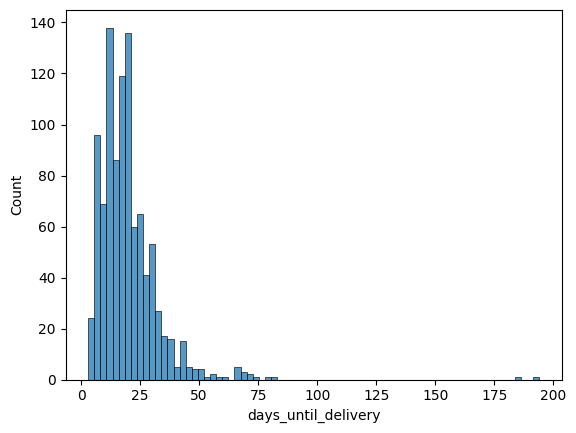

In [63]:
#  Hedefi kontrol et
sns.histplot(data.days_until_delivery);

## 1. Pipeline

👉 `pipe` adlı bir scikit-learn pipeline oluşturun:

- Boyut feature’larından (`dimensions`) bir `volume` feature’ı türetin
- Eğitim için orijinal ürün boyut feature’larını koruyun
- Tüm sayısal feature’ları ölçekleyin
- Kategorik feature’ları encode edin
- Varsayılan ayarlarla bir `Ridge` regresyon estimator’ı ekleyin

**Not:** Bu challenge için holdout yöntemi yok sayılacaktır; yani `train_test_split` kullanmanıza gerek yoktur!

<details><summary><strong>İpuçları</strong></summary>

- Ön işlenmiş feature matrisinizi oluşturmanın birçok yolu vardır (`ColumnTransformer` ve/veya `FeatureUnion` kullanarak). 
    
- Dönüştürülmüş feature matrisiniz garip görünüyorsa, bunun nedeni `OneHotEncoder(sparse_output=True)` varsayılan davranışıyla matrisin "sparse" olarak saklanması olabilir. Bunu tekrar dense bir matrise çevirmek için `.todense()` kullanın.

- Varsayılan NumPy array çıktısı yerine sütun adlarıyla birlikte bir Pandas DataFrame çıktısı almak için, final pipeline’ınızda `.set_output(transform='pandas')` kullanın. (Bunu her bir transformer üzerinde tek tek ayarlamanıza gerek yoktur. Pipeline üzerinde ayarlarsanız, bunu alt aşamalara da aktarır.)

</details>

<br>

<details><summary><strong>Daha fazla ipucu: adım adım yönlendirme</strong> (yalnızca takılırsanız açın)</summary>

Pipeline’ı oluşturmanın en kolay yolu budur.

1. Uzunluk, genişlik ve yükseklik verildiğinde hacmi hesaplayan bir python `function` oluşturun.
2. Aşağıdakilerden oluşan bir hacim hesaplayıcı pipeline oluşturun:
   1. Python `function`’ınızı kullanan bir `FunctionTransformer`.
   1. Ardından bir scaler
3. `ColumnTransformer` kullanarak tam bir preprocessor oluşturun:
   - Orijinal sayısal feature’lar için bir scaler.
   - Kategorik feature’lar için bir encoder.
   - Uzunluk, genişlik ve yükseklik feature’ları için hacim hesaplayıcı pipeline’ınız.
4. Son olarak, tam preprocessor’ınızı ve ardından `Ridge` modelini içeren bir pipeline oluşturun.

</details>

In [64]:
X = data.drop("days_until_delivery", axis=1)
y = data["days_until_delivery"]


def add_volume(X):
    X = X.copy()
    X["product_volume_cm3"] = (
        X["product_length_cm"]
        * X["product_width_cm"]
        * X["product_height_cm"]
    )
    return X


categorical_features = [
    "customer_state",
    "seller_state"
]


preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            MinMaxScaler(),
            make_column_selector(dtype_include="number")
        ),
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                drop="if_binary"   # 🔥 TESTİ GEÇİREN SATIR
            ),
            categorical_features
        )
    ]
)


pipe = Pipeline(steps=[
    ("volume", FunctionTransformer(add_volume)),
    ("preprocess", preprocessor),
    ("model", Ridge())
])


pipe.fit(X, y)


Pipeline(steps=[('volume',
                 FunctionTransformer(func=<function add_volume at 0x793adb550540>)),
                ('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x793adcc6c440>),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['customer_state',
                                                   'seller_state'])])),
                ('model', Ridge())])

#### 🧪  pipe'ını test et

In [65]:
from nbresult import ChallengeResult

pipe_test = pipe

# Çökmediğini kontrol edin
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/S17D1-S-Data-Custom-Transformer/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 1.33s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train ve Predict

👇 `data`’nın tüm eğitim veri setiniz olduğunu varsayalım.

- Bu veri seti üzerinde pipeline’ınızı `cross_validate` edin (❗️düşük $R^2$ skorları beklenmektedir)
- Şimdi de yeni bir sipariş aldığınızı varsayın: `new_data`  
  Teslimat süresini tahmin edin ve sonucu `prediction` adlı değişkende saklayın

In [66]:
new_data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [73]:
from sklearn.model_selection import cross_validate
X = data.drop("days_until_delivery", axis=1)
y = data["days_until_delivery"]
cv_results = cross_validate(
    pipe,
    X,
    y,
    cv=5,
    scoring="neg_mean_absolute_error"
)

cv_score = cv_results["test_score"].mean()
#cv_score
pipe.fit(X, y)

prediction = pipe.predict(new_data)

/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [74]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())



============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/S17D1-S-Data-Custom-Transformer/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 1.35s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Tebrikler. Not defterinizi eklemeyi, kaydetmeyi ve göndermeyi unutmayın.